# CF based recommender system using multi-layered neural networks
## Books for mystery, thriller, and crime
https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/home

In [1]:
import sys
sys.path.append('/home/014521052/venv-3.6.6-gpu/lib/python3.6/site-packages')

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

### Load Data

In [2]:
user_id_df = pd.read_csv('user_id_map.csv')
print(user_id_df.shape)
user_id_df.head(3)

(876145, 2)


,user_id_csv,user_id
0,0,8842281e1d1347389f2ab93d60773d4d
1,1,72fb0d0087d28c832f15776b0d936598
2,2,ab2923b738ea3082f5f3efcbbfacb218


In [3]:
book_id_df = pd.read_csv('book_id_map.csv')
print(book_id_df.shape)
book_id_df.head(3)

(2360650, 2)


,book_id_csv,book_id
0,0,34684622
1,1,34536488
2,2,34017076


In [4]:
books_df = pd.read_csv('goodreads_books_mystery_thriller_crime.csv')
books_df.authors = books_df.authors.str.split(pat = ",").str[0].str.split(pat=":").str[1].str.split(pat="'").str[1]
books_df = books_df.rename(columns={'authors': 'author_id'})
books_df.similar_books = books_df.similar_books.str.replace("^\[|\]$","")
print(books_df.shape)
books_df.head(3)

(219235, 29)


,asin,author_id,average_rating,book_id,country_code,description,edition_information,format,image_url,is_ebook,...,publication_year,publisher,ratings_count,series,similar_books,text_reviews_count,title,title_without_series,url,work_id
0,NaN,37778,3.93,6066814,US,"London, 1196. At the command of Richard the Li...",NaN,Hardcover,https://images.gr-assets.com/books/1328724803m...,False,...,2009.0,Simon & Schuster UK,186,['169353'],"'439108', '522621', '116770', '1275927', '6202...",15,"Crowner Royal (Crowner John Mystery, #13)","Crowner Royal (Crowner John Mystery, #13)",https://www.goodreads.com/book/show/6066814-cr...,6243149
1,B01NCIKAQX,242185,4.33,33394837,US,NaN,NaN,NaN,https://images.gr-assets.com/books/1493114742m...,True,...,NaN,NaN,269,['1052227'],,60,The House of Memory (Pluto's Snitch #2),The House of Memory (Pluto's Snitch #2),https://www.goodreads.com/book/show/33394837-t...,54143148
2,B01ALOWJN0,15104629,3.49,29074697,US,"BATHS, BANKS AND ROMAN INSURRECTION\nDetective...",NaN,NaN,https://s.gr-assets.com/assets/nophoto/book/11...,True,...,NaN,Amazon Digital Services,192,['953679'],,23,The Slaughtered Virgin of Zenopolis (Inspector...,The Slaughtered Virgin of Zenopolis (Inspector...,https://www.goodreads.com/book/show/29074697-t...,49305010


In [5]:
authors_df = pd.read_csv('goodreads_book_authors.csv')
print(authors_df.shape)
authors_df.head(3)

(829529, 5)


,author_id,average_rating,name,ratings_count,text_reviews_count
0,604031,3.98,Ronald J. Fields,49,7
1,626222,4.08,Anita Diamant,546796,28716
2,10333,3.92,Barbara Hambly,122118,5075


In [6]:
train_df = pd.read_csv('data/train.csv')
print(train_df.shape)
train_df.head(3)

(9876021, 3)


,user_id,book_id,rating
0,eabd6e8c6dc181d8fb5bd65573e9b51b,25365,3
1,f6bf54164ddeba9eb812c024aff1902c,8467921,3
2,7322c5cb2d2dc8a289374e8ae5c4903a,29960804,2


In [62]:
test_df = pd.read_csv('data/test.csv')
print(test_df.shape)
test_df.head(3)

(2549129, 3)


,user_id,book_id,rating
0,4374ea549de7ab51ce7ef59311babfee,17185496,4
1,f2fd8750f9b4b167e2eea57def6b0657,5349974,0
2,0e836dfd49f285f2e564145cd7ab245e,105992,5


### Data merge with user_id and book_id map

In [8]:
temp = pd.merge(train_df[['user_id', 'book_id', 'rating']], user_id_df[['user_id','user_id_csv']], on='user_id' )
trainSet = pd.merge(temp[['user_id', 'book_id', 'rating', 'user_id_csv']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(trainSet.shape)
trainSet.sample(3)

(9876021, 5)


,user_id,book_id,rating,user_id_csv,book_id_csv
3094014,8fcbce9d84a473997433b9e449d8eb2e,6838,4,238936,131980
2608946,9bfd20ec2c29b33eb780b8439546b2ac,13009682,4,406566,76777
1566930,9645c0a1b83377f0a635d0756f55bf32,2199587,3,129916,5739


In [9]:
temp = pd.merge(test_df[['user_id', 'book_id', 'rating']], user_id_df[['user_id','user_id_csv']], on='user_id' )
testSet = pd.merge(temp[['user_id', 'book_id', 'rating', 'user_id_csv']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(testSet.shape)
testSet.sample(3)

(2549129, 5)


,user_id,book_id,rating,user_id_csv,book_id_csv
935989,edde9f9cccada8b2170723c03483e446,22623990,3,199939,758525
2046278,a9852a29a8ede5e7b187bde5b235008a,818433,4,401432,146004
990552,7e4add3cf4841aff49628e3ebfd41995,32502,0,112311,55003


### Data Exploration

In [10]:
train_df.describe()

,book_id,rating
count,9.876021e+06,9.876021e+06
mean,8.298135e+06,3.605505e+00
std,9.922950e+06,1.311846e+00
min,1.640000e+02,0.000000e+00
25%,9.829300e+04,3.000000e+00
50%,2.429135e+06,4.000000e+00
75%,1.608548e+07,5.000000e+00
max,3.649449e+07,5.000000e+00


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9876021 entries, 0 to 9876020
Data columns (total 3 columns):
user_id    object
book_id    int64
rating     int64
dtypes: int64(2), object(1)
memory usage: 226.0+ MB


In [12]:
train_df.isnull().sum(axis=0)

user_id    0
book_id    0
rating     0
dtype: int64

In [13]:
num_users = train_df.book_id.nunique()
num_books = train_df.user_id.nunique()

print("Number of users: ", num_users)
print("Number of books: ", num_books)

Number of users:  211013
Number of books:  497178


rating=0, n=627848 (6.357%)
rating=1, n=153336 (1.553%)
rating=2, n=549580 (5.565%)
rating=3, n=2367284 (23.970%)
rating=4, n=3636165 (36.818%)
rating=5, n=2541808 (25.737%)


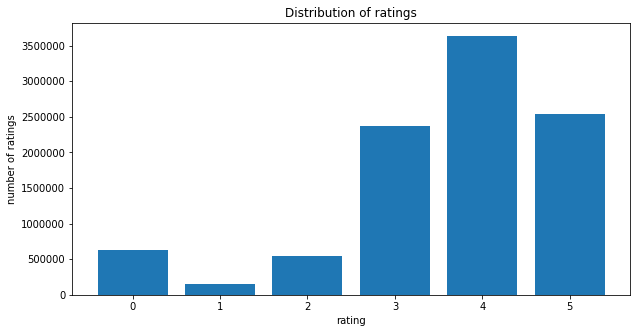

In [14]:
from collections import Counter

counter = Counter(sorted(train_df.rating))

for k,v in counter.items():
    per = v/len(train_df.rating)*100
    print('rating=%d, n=%d (%.3f%%)'%(k, v, per))

#plot class distribution
plt.figure(figsize=(10, 5))
plt.title('Distribution of ratings')
plt.bar(counter.keys(), counter.values())
plt.xlabel('rating')
plt.ylabel('number of ratings')
plt.show()

In [15]:
# split dataset into train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(trainSet, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((7900816, 5), (1975205, 5))

### Model Creation

In [16]:
import tensorflow as tf
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)

Tensorflow Version:  1.14.0
Keras Version:  2.2.4-tf


In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Concatenate
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import dot

In [18]:
def gen_MLP_model(n_factors, lr):
    #user input network
    input_users = Input(shape=[1])
    embed_users = Embedding(num_users + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-6))(input_users)
    users_out = Flatten()(embed_users)
    
    #book input network
    input_books = Input(shape=[1])
    embed_books = Embedding(num_books + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-6))(input_books)
    books_out = Flatten()(embed_books)

    conc_layer = Concatenate()([users_out, books_out])
    x = Dense(64, activation='relu')(conc_layer)
    x = Dropout(0.05)(x)   
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x) 
    x_out = x = Dense(1, activation='relu')(x)
    model = Model([input_users, input_books], x_out)
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )
      
    return model

In [19]:
def gen_MF_NN_model(n_factors, lr):
    #user input network
    input_users = Input(shape=(1,))
    embed_users = Embedding(num_users + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-4))(input_users)

    #book input network
    input_books = Input(shape=(1,))
    embed_books = Embedding(num_books + 1, 
                            n_factors,
                            embeddings_initializer='glorot_uniform',
                            embeddings_regularizer=l2(1e-4))(input_books)
    
    x_dot = Dot(2)([embed_users, embed_books])
    x = Flatten()(x_dot)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)   
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x) 
    x_out = x = Dense(1, activation='relu')(x)
    model = Model([input_users, input_books], x_out)
    
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mean_squared_error',
        metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE')]
    )
      
    return model

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='auto',
    restore_best_weights=True
    )

### Model Training and Validation

In [21]:
#set parameters
EmbedSize = 15 #30
Op_lr = 1e-1

BATCH_SIZE = 20000

In [22]:
#model = gen_MLP_model(n_factors=EmbedSize, lr=Op_lr)
#model.summary()
model = tf.keras.models.load_model('saved_model/RecSys_NN_model(n_epoch160).h5')
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 1)]          0                                            
________________

In [23]:
#set training condition
#----------------------
ENABLE = False
#----------------------

if ENABLE == True:
    n_start = 161
    n_iter = n_start+50

    for i in range(n_start, n_iter):
        history = model.fit(
            [X_train.user_id_csv, X_train.book_id_csv], X_train.rating,
            batch_size=BATCH_SIZE,
            epochs=1,
            validation_data=([X_test.user_id_csv, X_test.book_id_csv], X_test.rating)
        ) 

        model_name = 'RecSys_MLP_model(n_epoch%s)'%(i) + '.h5'
        print(model_name)
        model.save('saved_model/'+ model_name)


### Model Evaluation using test dataset

In [24]:
train_results = model.evaluate([X_train.user_id_csv, X_train.book_id_csv], X_train.rating, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, train_results):
  print(name, ': ', value)

loss :  1.0767313566239578
RMSE :  1.0190487


In [25]:
val_results = model.evaluate([X_test.user_id_csv, X_test.book_id_csv], X_test.rating, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, val_results):
  print(name, ': ', value)

loss :  1.6847285656658986
RMSE :  1.2831435


In [26]:
test_results = model.evaluate([testSet.user_id_csv, testSet.book_id_csv], testSet.rating, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, test_results):
  print(name, ': ', value)

loss :  1.706030526445323
RMSE :  1.2914176


### Model Prediction

In [63]:
pred = model.predict([testSet.user_id_csv, testSet.book_id_csv])

In [70]:
pred_df = pd.DataFrame(pred, columns=['pred_rating'])
print(pred_df.shape)
pred_df.head(3)

(2549129, 1)


,pred_rating
0,3.766951
1,3.766951
2,4.898899


In [72]:
pred_result=test_df.join(pred_df)
pred_result.head(3)

,user_id,book_id,rating,pred_rating
0,4374ea549de7ab51ce7ef59311babfee,17185496,4,3.766951
1,f2fd8750f9b4b167e2eea57def6b0657,5349974,0,3.766951
2,0e836dfd49f285f2e564145cd7ab245e,105992,5,4.898899


In [73]:
pred_result.to_csv(r'RecSys_NNmodel_pred_result.csv', index=False)

### Create Recommendation System

In [27]:
books = books_df[['book_id', 'author_id', 'average_rating', 'num_pages', 'description', 'similar_books', 'title']]
books_table = pd.merge(books[['book_id', 'author_id', 'average_rating', 'num_pages', 'description', 'similar_books', 'title']], book_id_df[['book_id','book_id_csv']], on='book_id' )
print(books_table.shape)
books_table.sample(3)

(219234, 8)


,book_id,author_id,average_rating,num_pages,description,similar_books,title,book_id_csv
26813,155327,51504,3.53,352.0,"When a human skeleton is unearthed, Carole and...","'293061', '17934488', '9468777', '956838', '12...","Murder in the Museum (Fethering, #4)",505676
151549,404834,35848,3.80,480.0,A debut crime thriller in which a woman appeal...,"'1538327', '748235', '379844', '1145402', '162...","Hen's Teeth (Kellen Stewart, #1)",731951
193878,6888153,93666,4.29,423.0,When a fight with her boyfriend drives Seattle...,"'43681', '6520386', '7427158', '505537', '7933...",The Dying Hour (Jason Wade #1),1062858


#### User-based TOP-10 Book Recommendation

In [28]:
N_TOP = 10

def user_based_recommendation(u_id, n_top=N_TOP):
    #get book list from books_table
    book_list = list(books_table.book_id_csv.unique())
    
    #create user array
    user_id = np.array([u_id for i in range(len(book_list))])

    #predict ratings for user
    pred = model.predict([user_id, np.array(book_list)])
    pred = pred.reshape(-1)
    
    #sort the array and get the index of N_TOP books with the higest ratings
    rec_books = (-pred).argsort()[0:n_top]

    return rec_books

In [29]:
USER_ID = 1

rec_books = user_based_recommendation(u_id=USER_ID)
books_table.iloc[rec_books]

,book_id,author_id,average_rating,num_pages,description,similar_books,title,book_id_csv
206409,10416071,746916,4.54,256.0,maarkin srkaarer atndr-prhraa bhed kre dbitiiy...,"'7936528', '1338762', '16145672', '2381078', '...",বিশ্বাসঘাতক,144834
146955,594139,2001717,4.21,410.0,A classic novel of romantic suspense finds the...,"'27695', '19089', '6138', '808879', '337113', ...",Rebecca,135401
213475,219635,52655,3.92,400.0,"Dressed in a cape and top hat, with a bone whi...","'822044', '197399', '1112967', '219472', '1791...","Ghoul (Special X, #2)",365643
115200,782047,8734,4.29,496.0,"Lord Peter Wimsey, eccentric amateur sleuth.\n...","'311916', '243399', '234319', '835701', '54180...",Lord Peter,154092
117120,487445,12465,4.13,512.0,This is the frighteningly true story of two yo...,"'333907', '55516', '255553', '805787', '372165...",The Onion Field,19066
213974,156925,90780,4.03,303.0,"Aud (it rhymes with ""shroud"" ) Torvingen is si...","'183690', '22598', '214618', '1251845', '33236...",Stay (Aud Torvingen #2),434717
153710,308251,91589,4.01,416.0,"Posing as jewel thief ""Donnie Brasco,"" FBI age...","'55517', '652063', '387627', '579190', '43652'...",Donnie Brasco,258158
35839,950269,27779,4.05,496.0,"The year is 1896, the place, New York City. On...","'1482299', '7640654', '583883', '49488', '1100...",The Alienist,99338
110807,6562913,9355,3.98,450.0,"Loop me in, odd one. The words, spoken in the ...","'64949', '268557', '3335890', '4673605', '4349...","Brother Odd (Odd Thomas, #3)",280467
6207,3074284,706255,4.22,569.0,Lisbeth Salander is a wanted woman. Two Millen...,"'39801', '13057652', '6304285', '3322382', '11...","The Girl Who Played with Fire (Millennium, #2)",289501


In [30]:
USER_ID = 20

rec_books = user_based_recommendation(u_id=USER_ID)
books_table.iloc[rec_books]

,book_id,author_id,average_rating,num_pages,description,similar_books,title,book_id_csv
152316,11079151,123715,3.90,166.0,NaN,"'19307664', '13127835', '11531343', '48785', '...",الحادث,38909
136257,439164,25413,4.19,628.0,Mystery aficionado Ellery Queen said of Cornel...,"'2563224', '543890', '441816', '854593', '1916...",The Cornell Woolrich Omnibus: Rear Window and ...,307170
176904,1235735,3389,4.19,1093.0,They were seven teenagers when they first stum...,"'11607', '11548', '32423', '11532', '32627', '...",It,83049
52888,123544,5293,4.27,NaN,NaN,"'16052466', '15157181', '13599701', '6902866',...","The Bourne Trilogy (Jason Bourne, #1-3)",273848
213475,219635,52655,3.92,400.0,"Dressed in a cape and top hat, with a bone whi...","'822044', '197399', '1112967', '219472', '1791...","Ghoul (Special X, #2)",365643
47407,29244700,2895706,3.92,320.0,How did Fox Mulder become a believer? How did ...,,"Agent of Chaos (The X-Files: Origins, #1)",83860
122288,22846899,8199367,4.63,292.0,Seattle Times reporter Ann Dexter is always on...,"'22670570', '24702554', '24325780', '24447560'...",Leap of Faith,441355
178617,18363191,6550683,3.98,348.0,It is the spring of 2005 and the macabre 'burn...,"'28468139', '13517050', '23782565', '461418', ...","Hungry Ghosts (Time, Blood and Karma, #2)",411870
19133,341587,10521,4.14,544.0,"In John T. Lescroart's brilliant new novel, Th...","'398406', '787903', '4683', '166196', '477567'...","The 13th Juror (Dismas Hardy, #4)",76823
37237,984050,1730,4.11,502.0,The year is 1327. Franciscans in a wealthy Ita...,"'12172', '625094', '94034', '123091', '65211',...",The Name of the Rose,60113


In [31]:
USER_ID = 50

rec_books = user_based_recommendation(u_id=USER_ID)
books_table.iloc[rec_books]

,book_id,author_id,average_rating,num_pages,description,similar_books,title,book_id_csv
116860,18710633,7359474,3.98,328.0,"1959. Key Largo, FL. The landscape of America ...","'19272342', '18132276', '18878076', '18136407'...",Unthinkable Consequences,346760
63309,6149338,746687,4.03,257.0,A man receives a photo of his girlfriend every...,"'5103426', '6154327', '6949682', '6707071', '1...",ZOO,381849
131425,7011527,47072,4.09,NaN,Fresh off the success of his Edgar Award-winni...,"'1395807', '102113', '2467322', '3861886', '83...",The Last Child,145344
173515,18310298,6465905,3.66,271.0,Blind psychiatrist Mark Angelotti has just enr...,"'17797428', '25392362', '18465936', '11509131'...",Dante's Poison (A Mark Angelotti Novel #2),162373
21762,33632753,16251039,4.28,300.0,Abigail Logan never expected to inherit a whis...,,Single Malt Murder (Whisky Business Mystery #1),496105
153865,30046028,4469744,4.08,395.0,Fergus Fletcher is a hit man. For five thousan...,,How to Kill Friends and Implicate People (Sam ...,464724
142421,790316,5293,3.98,523.0,Robert Ludlum's most famous character comes to...,"'5327061', '19691', '540020', '21838', '154424...","The Bourne Identity (Jason Bourne, #1)",263488
97057,13330314,274986,4.10,342.0,"""Edgar-finalist Hallinan's heartrending, unfor...","'11522441', '16027906', '25027342', '8892501',...",The Fear Artist,142464
9903,19549108,7579465,4.50,216.0,Life ain't easy for a regular guy in this town...,,Monster City,152413
28050,28351603,4404110,4.20,NaN,The next exciting installment in the bestselli...,,Twisted Justice,490897


In [32]:
USER_ID = 100

rec_books = user_based_recommendation(u_id=USER_ID)
books_table.iloc[rec_books]

,book_id,author_id,average_rating,num_pages,description,similar_books,title,book_id_csv
66842,1311450,93666,4.19,352.0,The face in the mirror belongs to a man Sister...,"'16088034', '18461422', '22391687', '25844044'...","A Perfect Grave (Jason Wade, #3)",393948
69323,1134720,2887,4.21,544.0,"We are behind, and below, the scenes of JFK's ...","'307443', '30004', '14326', '277875', '1916191...",American Tabloid,460332
157749,649070,349203,4.12,168.0,The strange and gruesome crime-scene snapshot ...,"'1048715', '19033', '832075', '849863', '21598...",Death Scenes: A Homicide Detective's Scrapbook,41616
105206,23361154,4389526,4.23,304.0,When family man Joe Crawford confronts a young...,"'17929809', '25547303', '15852625', '22434155'...",The Nightmare Girl,196130
29246,18670579,5312609,3.80,366.0,"Fall, 1995.\nHolson is a sleepy, middle-class ...","'18737669', '17309892', '18107102', '17305412'...",Neighborhood Watch,371149
90135,12292211,706255,4.22,724.0,"The Girl in the Spider's Web, the new book in ...","'39801', '13057652', '6304285', '3322382', '11...",The Girl Who Played with Fire,251848
18982,18649555,6396670,3.27,350.0,"In the 1980s, the Confetti Killer terrorized C...","'18593710', '17913381', '18428220', '25208005'...",The Confetti Killer,296044
57127,25218070,13710620,3.88,226.0,"When your life is a lie, how do you know what'...","'21385579', '23249950', '295435', '20653375', ...",They Call Me Alexandra Gastone (Alexandra Gast...,204648
192662,34439742,7873610,4.81,NaN,NaN,,REGINALD BONES 3,198122
175883,1518716,599793,3.89,458.0,"Celibataire parisienne sans histoires, Yael es...","'1508176', '1272848', '980397', '1693064', '25...","Les Arcanes du chaos (Le Cycle de l'homme, #1)",152609


In [33]:
USER_ID = 2000

rec_books = user_based_recommendation(u_id=USER_ID)
books_table.iloc[rec_books]

,book_id,author_id,average_rating,num_pages,description,similar_books,title,book_id_csv
74657,26404155,6575113,3.91,288.0,When former foreign correspondent Lola Wicks h...,,"Disgraced (Lola Wicks, #3)",431274
192554,7794447,3397246,3.76,343.0,"Whenever a plane goes down in the U.S., a ""Go ...","'174395', '996726', '9515469', '377651', '2589...",Crashers,224061
1965,15801651,57542,4.02,399.0,It's the year 2032 and the president claims Am...,"'600956', '13586092', '13237862', '18405708', ...","Heroes Proved (Peter Newman, #4)",247909
143932,15776089,5756976,4.19,346.0,"Eric Riordan doesn't look for trouble, but tro...","'25495455', '28366502', '26311145', '20883590'...","This Shattered Land (Surviving the Dead, #2)",360567
57108,21856154,10289,3.71,224.0,Dennis Lehane returns to the streets ofMystic ...,"'17333232', '9537350', '10119401', '8540960', ...",The Drop,237263
1071,17225339,12577,4.03,612.0,"After his wife, Helen, is brazenly abducted be...","'11007668', '16065538', '86736', '219403', '19...",Two Graves,398387
92723,18521863,785619,3.77,265.0,Will protecting children throughout the world ...,"'19505763', '18523510', '18367881', '30010311'...",Blog This (Tenderness and Terror #1),460543
122736,24874326,3565,3.78,64.0,"'He was not blind to the fact that murder, lik...","'24874314', '24874349', '24874347', '24874304'...",Lord Arthur Savile's Crime,71906
87725,22241361,8253345,4.06,296.0,How do you love someone who exists entirely in...,"'7927995', '20699996', '25812851', '20691958',...","Love is a Stranger (More Heat Than the Sun, #1)",180108
203115,1072035,24655,3.88,291.0,NaN,"'166670', '185629', '673189', '171759', '65861...","The Queen's Man (Justin de Quincy, #1)",148771
